In [1]:
!pip install tensorflow


In [2]:
import pandas as pd
import numpy as np
import re
import keras

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("data/train.csv")
df = df[['user_review', 'user_suggestion']].dropna()

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_review'] = df['user_review'].apply(clean_text)

In [5]:
df = df.sample(2000, random_state=42)


In [6]:
MAX_WORDS = 10000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_review'])

sequences = tokenizer.texts_to_sequences(df['clean_review'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

X = padded
y = df['user_suggestion'].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/Users/canse/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5860 - loss: 0.6866 - val_accuracy: 0.5875 - val_loss: 0.6792
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6094 - loss: 0.6822 - val_accuracy: 0.6000 - val_loss: 0.6746
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6256 - loss: 0.6718 - val_accuracy: 0.5650 - val_loss: 0.6831
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6423 - loss: 0.6422 - val_accuracy: 0.5925 - val_loss: 0.6814
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6628 - loss: 0.6174 - val_accuracy: 0.6025 - val_loss: 0.7188


In [11]:
model.save("lstm_review_model.h5")


In [12]:
loaded_model = load_model("lstm_review_model.h5")


In [13]:
def predict_review(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded_seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post')
    pred = loaded_model.predict(padded_seq)
    return "👍 Recommande" if pred[0][0] > 0.5 else "👎 Ne recommande pas"

print(predict_review("This game is fantastic, I love it!"))
print(predict_review("Terrible experience, waste of time."))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
👍 Recommande
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
👍 Recommande


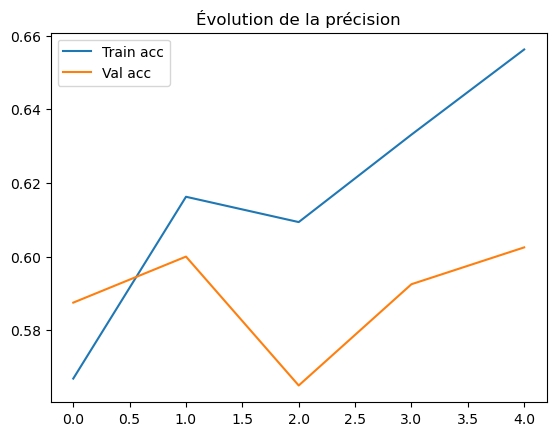

In [15]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.title("Évolution de la précision")
plt.show()